In [137]:
# 라이브러리 불러오기
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import asyncio
import json
import nest_asyncio
import pandas as pd
import re
from tqdm import tqdm
nest_asyncio.apply()

In [138]:
urls = pd.read_csv("../data/textom_1122_SBS.csv")

In [139]:
urls

,Unnamed: 0,0,1
0,0,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
1,1,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
2,2,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
3,3,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
4,4,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
...,...,...,...
668,668,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
669,669,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
670,670,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
671,671,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...


In [140]:
# 함수 정의
def get_comments(refer_url, comment_url) : # 댓글 목록을 json 형태로 받아오는 함수
    comments = []
    next = None
    # 처음엔 댓글 개수를 모르므로 충분히 큰 수를 넣어 줌
    comment_count = 10e6
    headers = {
        'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.5 Safari/605.1.15',
        'referer': refer_url
    }
    
    # 수집한 댓글 수가 첫번째에 수집한 총 댓글 수 보다 많다면 반복을 종료합니다.
    while len(comments) < comment_count :
        comment_url_next = comment_url + '&moreParam.next=' + next if next else comment_url
        res = requests.get(comment_url_next, headers=headers)
        dic = json.loads(res.text[res.text.index('(')+1:-2])
        comments.extend(list(map(lambda x : {
            'text': x['contents'],
            'reply_count' : x['replyCount'], 
            'uid': x['idNo'],
            'uname' : x['userName'],
            'like': x['sympathyCount'], 
            'dislike': x['antipathyCount'],
            'c_time' : x['modTime'],
            'cid': x['commentNo'],
            'pid' : x['parentCommentNo'] 
            }, dic['result']['commentList'])))
        comment_count = dic['result']['count']['comment']
        next = dic['result']['morePage']['next'] if comment_count else None
    # 필터로 삭제된 댓글을 걸러줍니다
    comments=list(filter(lambda x: len(x['text']), comments))
    return comments



In [141]:
def get_data(oid, aid) :
    try :
        # refer_url: 댓글 보기를 누르면 나오는 댓글 페이지 주소
        # comment_url: 네트워크 탭에서 확인 가능한 동적으로 생성되는 주소
        refer_url = f'https://n.news.naver.com/mnews/article/comment/{oid}/{aid}?sid=100'
        comment_url = f'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=news&templateId=default_politics_m3&pool=cbox5&_cv=20220623185938&_callback=jQuery33103200637113167857_1656171100524&lang=ko&country=KR&objectId=news{oid}%2C{aid}&categoryId=&pageSize=100&indexSize=10&groupId=&listType=OBJECT&pageType=more&page=1&initialize=true&userType=&useAltSort=true&replyPageSize=20&followSize=100&sort=new&includeAllStatus=true&_=1656171100525'

        comments = get_comments(refer_url, comment_url)
        comments = pd.DataFrame(comments)
        # 댓글 수가 0개인 기사를 어떻게 할지 추후에 결정해야 함
        return comments
    except :
        return None


In [142]:
df = pd.DataFrame()
for url, vid in tqdm(zip(urls['0'], urls['1'])):
    try:
        oid = re.findall('article/([^\*]*)/', str(url))[0]
        aid = re.findall(f'{oid}/([^\*]*)[?]', str(url))[0]
        sid = url[-3:]
        temp = get_data(oid, aid)
        temp['vid'] = vid
        temp['sid'] = sid
        df =pd.concat([df, temp])
    except:
        print(url)

24it [00:12,  1.68it/s]

https://entertain.naver.com/read?oid=416&aid=0000289411
https://entertain.naver.com/read?oid=416&aid=0000289410


90it [00:50,  1.25s/it]

https://n.news.naver.com/sports/qatar2022/article/055/0001010811


95it [00:52,  2.06it/s]

https://entertain.naver.com/read?oid=416&aid=0000289160


100it [00:54,  2.88it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001010009


111it [01:05,  1.79it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009910


121it [01:09,  2.08it/s]

https://entertain.naver.com/read?oid=416&aid=0000289057


124it [01:10,  3.53it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009772


133it [01:11,  4.45it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009718


150it [01:18,  1.84it/s]

https://entertain.naver.com/read?oid=416&aid=0000289036


172it [01:27,  4.20it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009473


194it [01:34,  2.75it/s]

https://entertain.naver.com/read?oid=416&aid=0000289123


196it [01:34,  4.02it/s]

https://entertain.naver.com/read?oid=416&aid=0000289120


220it [01:42,  4.40it/s]

https://entertain.naver.com/read?oid=416&aid=0000289080


223it [01:43,  3.23it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001010077


235it [01:55,  2.63it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009422


238it [01:56,  3.16it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009401


245it [01:57,  4.19it/s]

https://entertain.naver.com/read?oid=416&aid=0000289020
https://entertain.naver.com/read?oid=416&aid=0000289017


257it [02:08,  1.09s/it]

https://entertain.naver.com/read?oid=416&aid=0000289014
https://entertain.naver.com/read?oid=416&aid=0000289012


280it [02:16,  3.08it/s]

https://entertain.naver.com/read?oid=416&aid=0000289484


316it [02:41,  3.14s/it]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001010008


332it [02:50,  1.90it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009870


351it [02:57,  4.23it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009719


373it [03:09,  1.30it/s]

https://entertain.naver.com/read?oid=416&aid=0000289037
https://entertain.naver.com/read?oid=416&aid=0000289047


414it [03:35,  2.00it/s]

https://entertain.naver.com/read?oid=416&aid=0000289154


431it [03:40,  2.48it/s]

https://entertain.naver.com/read?oid=416&aid=0000289122


495it [04:22,  3.50it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009576


497it [04:23,  4.60it/s]

https://entertain.naver.com/read?oid=416&aid=0000289030


517it [04:33,  2.33it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009434


524it [04:36,  2.93it/s]

https://entertain.naver.com/read?oid=416&aid=0000289021


527it [04:37,  4.10it/s]

https://sports.news.naver.com/news.nhn?oid=055&aid=0001009355


541it [04:42,  2.36it/s]

https://entertain.naver.com/read?oid=416&aid=0000289099


545it [04:43,  4.83it/s]

https://entertain.naver.com/read?oid=416&aid=0000289086


565it [04:53,  1.73it/s]

https://entertain.naver.com/read?oid=416&aid=0000289075


596it [05:05,  4.14it/s]

https://entertain.naver.com/read?oid=416&aid=0000289035


608it [05:11,  1.53it/s]

https://entertain.naver.com/read?oid=416&aid=0000289022
https://entertain.naver.com/read?oid=416&aid=0000289023


632it [05:24,  3.52it/s]

https://entertain.naver.com/read?oid=416&aid=0000289019


643it [05:29,  2.40it/s]

https://entertain.naver.com/read?oid=416&aid=0000289015
https://sports.news.naver.com/news.nhn?oid=055&aid=0001009349


673it [05:59,  1.87it/s]


In [143]:
df['media'] = 'SBS'

In [144]:
df.reset_index(drop=True)

,text,reply_count,uid,uname,like,dislike,c_time,cid,pid,vid,sid,media
0,부실대응이 아니다 사고현장 근처에서 쳐다보면서 사고나 다 죽은다음에 나타난 이임재 ...,0.0,8UQLL,sktp****,0.0,0.0,2022-11-16T18:30:09+0900,775140889709248570,775140889709248570,https://news.sbs.co.kr/news/endPage.do?news_id...,100,SBS
1,언제부터 우리나라 법무장관이 정치중심에서 시시콜콜 나서서 지랄을했나 일개장관이 날마...,0.0,6jaic,ig17****,0.0,0.0,2022-11-16T09:12:52+0900,775104987272315249,775104987272315249,https://news.sbs.co.kr/news/endPage.do?news_id...,100,SBS
2,저런 좌빨 국개 반역자들에게 세비와 보좌진의 급여로 국민혈세가 나가는게 너무나 아깝다.,0.0,1ATdw,psh7****,0.0,0.0,2022-11-16T09:12:15+0900,775104948047183996,775104948047183996,https://news.sbs.co.kr/news/endPage.do?news_id...,100,SBS
3,한장관 이런쓰레기들입에담지마라,0.0,6sWuV,guho****,0.0,0.0,2022-11-16T05:55:51+0900,775092295039975641,775092295039975641,https://news.sbs.co.kr/news/endPage.do?news_id...,100,SBS
4,깐죽싸패관종동훈이를 끝장내라 천명한다,0.0,3nMIC,drea****,0.0,1.0,2022-11-16T03:41:29+0900,775083638466281615,775083638466281615,https://news.sbs.co.kr/news/endPage.do?news_id...,100,SBS
...,...,...,...,...,...,...,...,...,...,...,...,...
66079,베트남간 김진태도 그렇고 얘네는 일터졌는데 해외 나가있나.,0.0,MlGd,eyw0****,19.0,9.0,2022-10-30T03:42:45+0900,773506607374926035,773506607374926035,https://news.sbs.co.kr/news/endPage.do?news_id...,102,SBS
66080,정치병자들 구경왔다 이런 사고에도 대가리가 그런쪽밖에 안굴러가네 명복은 못 빌어줄망...,0.0,1sUf6,park****,1.0,3.0,2022-10-30T03:41:47+0900,773506545332781263,773506545332781263,https://news.sbs.co.kr/news/endPage.do?news_id...,102,SBS
66081,입에 재갈물리고 정치적 입단속은 시키면서 .... 간신히 선거권...,0.0,3OM2u,doga****,4.0,6.0,2022-10-30T03:38:12+0900,773506314545397825,773506314545397825,https://news.sbs.co.kr/news/endPage.do?news_id...,102,SBS
66082,유럽? 구태 그대로구나,0.0,5lvOG,tjrt****,2.0,3.0,2022-10-30T03:33:10+0900,773505990359253041,773505990359253041,https://news.sbs.co.kr/news/endPage.do?news_id...,102,SBS


In [145]:
df.reset_index(drop=True).to_pickle('../result/textom_SBS_comments.pkl')
df.reset_index(drop=True).to_csv('../result/textom_SBS_comments.csv')

In [146]:
df['ymd'] = df.c_time.apply(lambda x : x[:10])

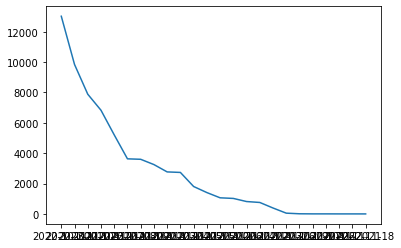

In [147]:
import matplotlib.pyplot as plt

plt.plot(df['ymd'].value_counts())

In [148]:
urls

,Unnamed: 0,0,1
0,0,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
1,1,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
2,2,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
3,3,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
4,4,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
...,...,...,...
668,668,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
669,669,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
670,670,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...
671,671,https://n.news.naver.com/mnews/article/055/000...,https://news.sbs.co.kr/news/endPage.do?news_id...


In [149]:
news = pd.read_excel("/home/mglee/VSCODE/git_folder/TEXTOM/data/2022-11-22 16_23_54_2354_.xlsx")

In [150]:
news

,"국가 배상 소송 본격화…정부 ""선제적 배상 검토""",https://news.sbs.co.kr/news/endPage.do?news_id=N1006972031&plink=SEARCH&cooper=SBSNEWSSEARCH,"&<앵커&> 이런 가운데 국가를 상대로 손해배상 소송을 준비하는 유족들도 있습니다. 정부는 수사 결과에 따라서 먼저 보상금 또는 배상금을 지급할 가능성도 있다고 밝혔습니다. 이 내용은 박찬근 기자가 전하겠습니다. &<기자&> 참사의 국가 책임을 묻겠다며 열 가족이 한 변호사단체가 운영하는 공익 제보 센터 문을 두드렸습니다. 결혼식을 6개월 앞두고 숨진 예비부부의 양가 부모, 20대 새내기 직장인의 유족 등 각자 사연은 다르지만, 참사 원인을 규명해 책임이 국가에 있음을 밝히겠다는 의지는 같습니다. [전수미/굿로이어스 공익제보센터 변호사 : 결혼식이 아니라 하늘로 보내야 했던 입장이라서 너무나 많이 힘들어 하시고. 아이들을 잊고 싶어하지 않고 아이들을 위해서 행동하고 싶어 하시는 거죠.] 국가배상법에 따라 참사가 예견되는 상황에도 경찰관 직무집행법 등에 따른 예방 조치를 고의 또는 과실로 하지 않았다는 게 수사로 확인되면 배상 책임이 성립할 수 있습니다. 112 신고를 받은 경찰의 미흡한 대처로 여성이 살해당한 오원춘 사건, 경찰과 보호관찰관의 허술한 수사와 감독이 주부 살인으로 이어진 중곡동 사건 등에서 대법원은 국가의 책임을 인정한 적 있습니다. 국가의 직무상 의무 위반과 피해자 사망 사이의 인과관계가 있는 만큼 국가 책임이 있다고 본 건데, 이태원 참사의 국가 배상도 경찰과 구청 등의 직무 위반이 압사와 인과관계가 있는지가 판단 기준이 될 걸로 보입니다. 정부는 선제적인 배상 가능성도 열어두고 있습니다. [한동훈/법무부 장관 : 수사 결과에 따라서 정부가 책임 있는 피해 구제를 할 것이라고 생각합니다.] [김한규/민주당 의원 : (정부가) 먼저 보상금, 또는 배상금을 지급할 가능성도 있습니까?] [한동훈/법무부 장관 : 당연합니다. 당연한 말씀이죠.] 대한변호사협회와 민주사회를 위한 변호사모임도 유족들의 국가 배상 청구를 지원하겠다고 밝혔습니다. (영상취재 : 강동철·김세경, 영상편집 : 원형희, CG : 류상수) ▶ [단독] 대구 핼러윈엔 기동대…&'국가 책임 법리 검토&' ▶ 행안부 · 서울시 관계자 줄소환…&apos;재난상황실&apos; 정조준"
0,"국회 행안위, 내일 이임재 전 용산서장 불러 &apos;부실대응&apos; 추궁",https://news.sbs.co.kr/news/endPage.do?news_id...,국회 행정안전위원회는 내일(16일) 오후 전체회의에 이태원 참사 당시 현장 총괄 책...
1,"이상민 ""현장 실무자 수사, &apos;꼬리 자르기&apos; 아니다""",https://news.sbs.co.kr/news/endPage.do?news_id...,이상민 행정안전부 장관은 경찰 특별수사본부의 이태원 참사 수사가 당시 현장에 있던 ...
2,"한중 정상, G20 회의장서 사전 환담…시진핑 ""오늘 회담 기대""",https://news.sbs.co.kr/news/endPage.do?news_id...,"윤석열 대통령은 15일(현지시간) 인도네시아 발리에서 개막한 주요 20개국, G20..."
3,"특수본, 피의자 조사 본격화…용산서 정보과장 소환",https://news.sbs.co.kr/news/endPage.do?news_id...,이태원 참사를 수사 중인 경찰 특별수사본부(특수본)는 오늘(15일) 낮 2시 핼러윈...
4,"법원 ""박원순 성희롱 인정한 국가인권위 결정 적절""",https://news.sbs.co.kr/news/endPage.do?news_id...,서울행정법원은 고 박원순 전 서울시장이 부하직원을 성희롱했다고 본 국가인권위원회의 ...
...,...,...,...
994,"서울시, 이태원 일대 임시 버스·지하철 투입…""속히 귀가""",https://news.sbs.co.kr/news/endPage.do?news_id...,▲ 이태원 사고 현장 서울시는 대형 압사 참사가 발생한 용산구 이태원 일대에 임시 ...
995,""" 이태원 압사 참사 사망자 120명, 상당수가 20대""",https://news.sbs.co.kr/news/endPage.do?news_id...,&<앵커&> 지금 이태원 사고 현장에 나가 있는 손기준 기자 연결해보겠습니다. 손 ...
996,"尹, &apos; 이태원 사고&apos; 긴급회의…""이송·치료 외 차량·인원 통제""",https://news.sbs.co.kr/news/endPage.do?news_id...,윤석열 대통령이 서울 이태원 핼러윈 행사에서 대규모 인파가 몰리면서 발생한 사고와 ...
997,"서울시 ""&apos;급거 귀국&apos; 오세훈 시장, 오후 4시 10분쯤 도착""",https://news.sbs.co.kr/news/endPage.do?news_id...,유럽 출장 중인 오세훈 서울시장이 서울 용산구 이태원동에서 대규모 압사 사고가 발생...


In [151]:
news.columns = ['title', 'vid', 'body']

In [152]:
df_merge = pd.merge(df, news, left_on = 'vid', right_on = 'vid')

In [153]:
df_merge.to_pickle('../result/textom_SBS_comments.pkl')
df_merge.to_csv('../result/textom_SBS_comments.csv')

# MERGE ALL

In [154]:
df_KBS = pd.read_pickle(('../result/textom_KBS_comments.pkl'))
df_SBS = pd.read_pickle(('../result/textom_SBS_comments.pkl'))
df_MBC = pd.read_pickle(('../result/textom_MBC_comments.pkl'))

In [155]:
df_all = pd.concat([df_KBS, df_SBS, df_MBC])

In [176]:
df_all.reset_index(drop = True).to_csv("../result/textom_comments_all.csv")

In [156]:
import matplotlib.pyplot as plt


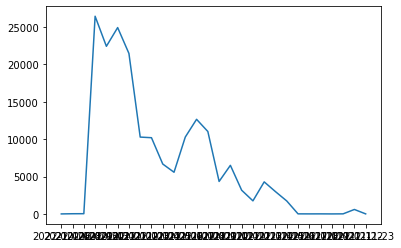

In [177]:
plt.plot(df_all.groupby('ymd').size().sort_index())

In [184]:
df_SBS.groupby('ymd').size().sort_index()

ymd
2022-10-26        4
2022-10-30    13018
2022-10-31     6827
2022-11-01     9843
2022-11-02     7884
2022-11-03     2767
2022-11-04     2733
2022-11-05     1806
2022-11-06     1021
2022-11-07     5205
2022-11-08     3628
2022-11-09     3598
2022-11-10     1062
2022-11-11     3250
2022-11-12      755
2022-11-13      390
2022-11-14      816
2022-11-15     1407
2022-11-16       51
2022-11-17        4
2022-11-18        1
2022-11-19       10
2022-11-20        2
2022-11-21        2
dtype: int64

In [231]:
temp = pd.DataFrame(df_all.groupby('ymd').size().sort_index())
temp['0'] = 0


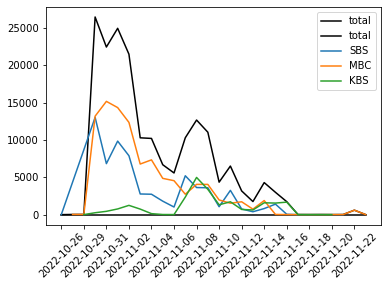

In [236]:
xs = temp.sort_index().index

plt.plot(temp, label = 'total', color = 'black')
plt.plot(df_SBS.groupby('ymd').size().sort_index(), label = "SBS")
plt.plot(df_MBC.groupby('ymd').size().sort_index(), label = "MBC")
plt.plot(df_KBS.groupby('ymd').size().sort_index(), label = "KBS")
    
plt.xticks(ticks=xs, labels= xs, rotation = 45)
plt.locator_params(axis = 'x', nbins = 15)  
plt.legend()


In [172]:
df_MBC.groupby('ymd').size().sort_index()

ymd
2022-10-28       28
2022-10-29       26
2022-10-30    13179
2022-10-31    15160
2022-11-01    14328
2022-11-02    12347
2022-11-03     6773
2022-11-04     7332
2022-11-05     4856
2022-11-06     4546
2022-11-07     2734
2022-11-08     4052
2022-11-09     4047
2022-11-10     1967
2022-11-11     1531
2022-11-12     1723
2022-11-13      735
2022-11-14     1887
2022-11-15       29
2022-11-16       11
2022-11-17        3
2022-11-18        4
2022-11-21       11
2022-11-22      599
2022-11-23        9
dtype: int64